<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula10a_dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [4]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [ ]:
def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" 
              for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname, 
                      dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [6]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape: ", data_batch.shape)
  print("labels batch shape: ", labels_batch.shape)
  break

data batch shape:  (32, 180, 180, 3)
labels batch shape:  (32,)


In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convner_from_scratch.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]

In [8]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 11s 83ms/step - loss: 0.7036 - accuracy: 0.5220 - val_loss: 0.6916 - val_accuracy: 0.5030
Epoch 2/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6931 - accuracy: 0.5210 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 5s 69ms/step - loss: 0.6862 - accuracy: 0.5805 - val_loss: 0.7599 - val_accuracy: 0.5040
Epoch 4/30
63/63 [==============================] - 4s 64ms/step - loss: 0.6429 - accuracy: 0.6410 - val_loss: 0.6025 - val_accuracy: 0.6810
Epoch 5/30
63/63 [==============================] - 5s 81ms/step - loss: 0.5979 - accuracy: 0.6820 - val_loss: 0.6131 - val_accuracy: 0.6710
Epoch 6/30
63/63 [==============================] - 4s 64ms/step - loss: 0.5688 - accuracy: 0.6940 - val_loss: 0.6161 - val_accuracy: 0.6610
Epoch 7/30
63/63 [==============================] - 6s 86ms/step - loss: 0.5325 - accuracy: 0.7225 - val_loss: 0.5679 - val_accuracy: 0.7220
Epoch 8/30
6

In [9]:
test_model = keras.models.load_model("convner_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 34ms/step - loss: 0.5850 - accuracy: 0.7025
Test accuracy: 0.702


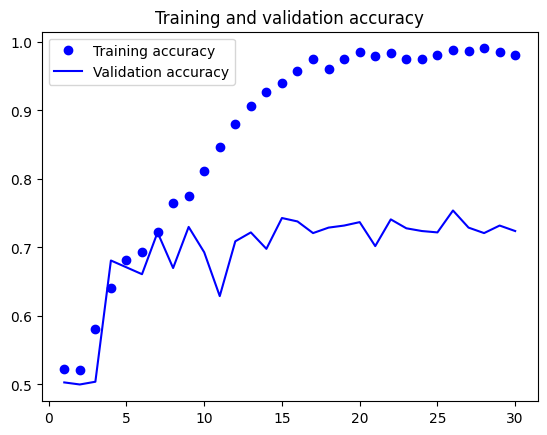

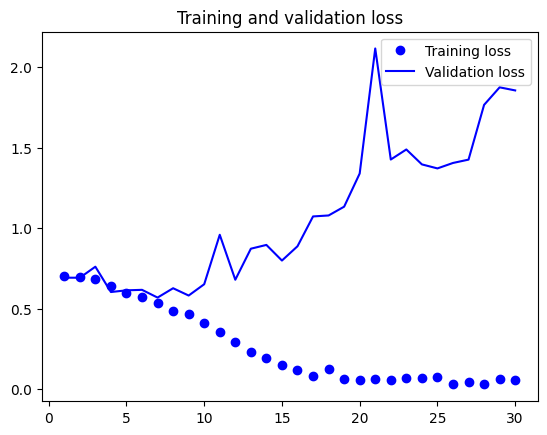

In [10]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

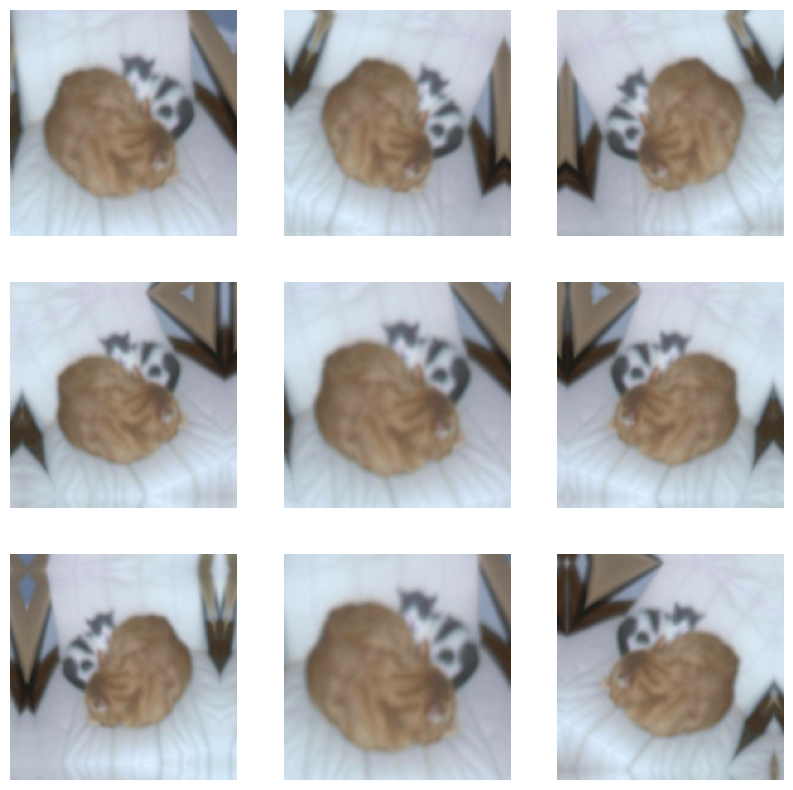

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
     

In [13]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [14]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
  train_dataset,
  epochs=100,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 7s 68ms/step - loss: 0.6986 - accuracy: 0.4950 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 5s 73ms/step - loss: 0.6935 - accuracy: 0.5090 - val_loss: 0.6919 - val_accuracy: 0.5540
Epoch 3/100
63/63 [==============================] - 5s 68ms/step - loss: 0.6935 - accuracy: 0.5205 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 4s 65ms/step - loss: 0.6868 - accuracy: 0.5590 - val_loss: 0.6812 - val_accuracy: 0.5460
Epoch 5/100
63/63 [==============================] - 5s 81ms/step - loss: 0.6694 - accuracy: 0.5965 - val_loss: 0.6738 - val_accuracy: 0.5830
Epoch 6/100
63/63 [==============================] - 4s 65ms/step - loss: 0.6601 - accuracy: 0.6025 - val_loss: 0.6824 - val_accuracy: 0.5750
Epoch 7/100
63/63 [==============================] - 6s 87ms/step - loss: 0.6493 - accuracy: 0.6285 - val_loss: 0.6404 - val_accuracy: 0.6350
Epoch 

In [15]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 35ms/step - loss: 0.4528 - accuracy: 0.8360
Test accuracy: 0.836


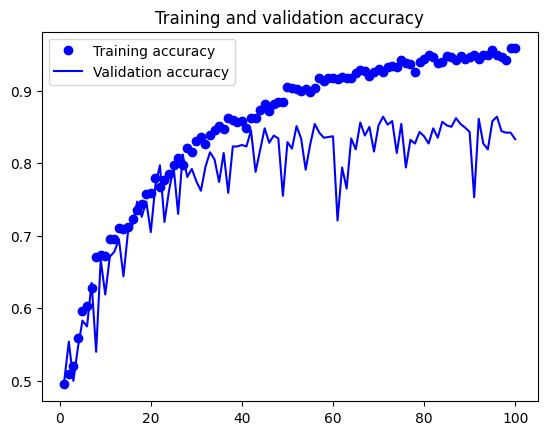

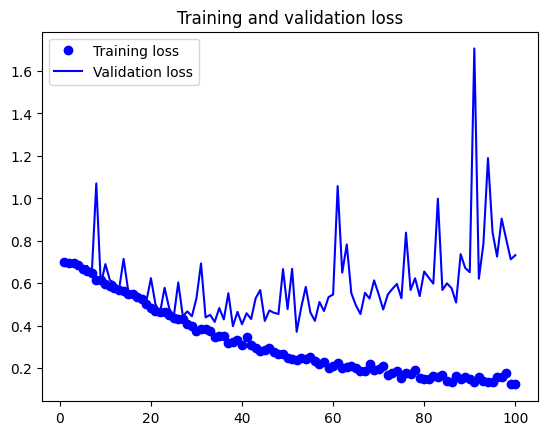

In [16]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [17]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                           

In [19]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
  train_dataset,
  epochs=50,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 17s 192ms/step - loss: 20.5037 - accuracy: 0.8970 - val_loss: 3.1377 - val_accuracy: 0.9690
Epoch 2/50
63/63 [==============================] - 10s 149ms/step - loss: 7.1724 - accuracy: 0.9425 - val_loss: 3.0536 - val_accuracy: 0.9730
Epoch 3/50
63/63 [==============================] - 10s 150ms/step - loss: 5.7128 - accuracy: 0.9545 - val_loss: 3.6998 - val_accuracy: 0.9720
Epoch 4/50
63/63 [==============================] - 11s 176ms/step - loss: 4.5667 - accuracy: 0.9650 - val_loss: 10.0734 - val_accuracy: 0.9450
Epoch 5/50
63/63 [==============================] - 11s 175ms/step - loss: 4.7880 - accuracy: 0.9600 - val_loss: 4.2153 - val_accuracy: 0.9720
Epoch 6/50
63/63 [==============================] - 11s 178ms/step - loss: 3.5942 - accuracy: 0.9630 - val_loss: 3.4199 - val_accuracy: 0.9750
Epoch 7/50
63/63 [==============================] - 9s 141ms/step - loss: 2.7267 - accuracy: 0.9670 - val_loss: 4.2972 - val_accuracy: 0.971

In [20]:
test_model = keras.models.load_model(
  "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 90ms/step - loss: 1.9028 - accuracy: 0.9805
Test accuracy: 0.980


#Fine-tuning

In [25]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0   

In [26]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
  train_dataset,
  epochs=50,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 13s 167ms/step - loss: 3.2605 - accuracy: 0.7990 - val_loss: 0.6581 - val_accuracy: 0.9340
Epoch 2/50
63/63 [==============================] - 13s 199ms/step - loss: 1.1969 - accuracy: 0.8885 - val_loss: 0.3949 - val_accuracy: 0.9520
Epoch 3/50
63/63 [==============================] - 11s 165ms/step - loss: 0.7101 - accuracy: 0.9170 - val_loss: 0.2915 - val_accuracy: 0.9600
Epoch 4/50
63/63 [==============================] - 11s 166ms/step - loss: 0.4724 - accuracy: 0.9255 - val_loss: 0.2387 - val_accuracy: 0.9600
Epoch 5/50
63/63 [==============================] - 13s 197ms/step - loss: 0.2782 - accuracy: 0.9340 - val_loss: 0.2042 - val_accuracy: 0.9670
Epoch 6/50
63/63 [==============================] - 12s 193ms/step - loss: 0.2668 - accuracy: 0.9390 - val_loss: 0.1879 - val_accuracy: 0.9710
Epoch 7/50
63/63 [==============================] - 12s 194ms/step - loss: 0.1703 - accuracy: 0.9560 - val_loss: 0.1818 - val_accuracy: 0.9700

In [27]:
test_model = keras.models.load_model(
  "fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 89ms/step - loss: 0.1711 - accuracy: 0.9770
Test accuracy: 0.977
